In [3]:
# Import necessary libraries.
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
file = tf.keras.utils
raw_df = pd.read_csv('./creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [7]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [8]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


/Users/johnnydevriese/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/johnnydevriese/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


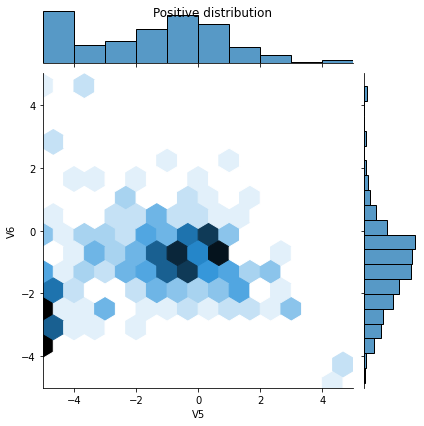

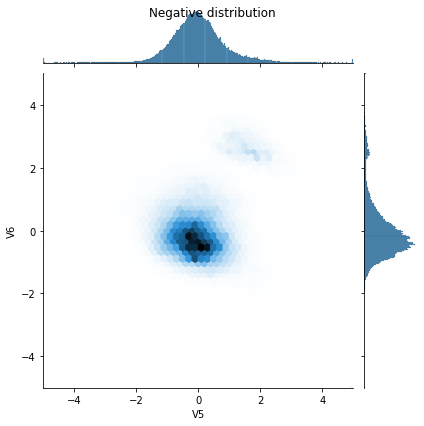

In [10]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='true positive'),
      keras.metrics.FalsePositives(name='false positive'),
      keras.metrics.TrueNegatives(name='true negative'),
      keras.metrics.FalseNegatives(name='false negative'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

# Baseline Model

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
# Create and train the model by calling the `make_model()` function.
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.predict(train_features[:10])

2022-01-05 15:45:40.957346: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-05 15:45:40.957552: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


array([[0.5718938 ],
       [0.9578531 ],
       [0.48555294],
       [0.38280708],
       [0.39884338],
       [0.18077362],
       [0.3778038 ],
       [0.85698396],
       [0.5097802 ],
       [0.41451403]], dtype=float32)

# Set better initial bias 

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.9362


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [17]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00228986],
       [0.00316817],
       [0.00424775],
       [0.00109661],
       [0.00135592],
       [0.00243115],
       [0.00286371],
       [0.00086367],
       [0.00095445],
       [0.00517303]], dtype=float32)

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0160


The initial loss is now 50x less than with naive initilization! 

In [19]:
# checkpoint weights

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

# confirm that bias init has helped 

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

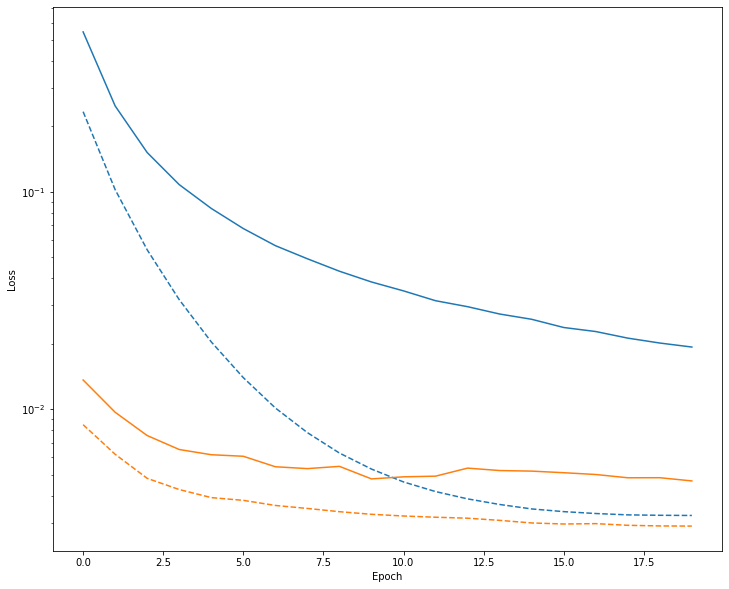

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

# Train the model

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 1s 4ms/step - loss: 0.0138 - true positive: 85.0000 - false positive: 41.0000 - true negative: 227411.0000 - false negative: 308.0000 - accuracy: 0.9985 - precision: 0.6746 - recall: 0.2163 - auc: 0.7032 - prc: 0.2490 - val_loss: 0.0086 - val_true positive: 1.0000 - val_false positive: 0.0000e+00 - val_true negative: 45487.0000 - val_false negative: 81.0000 - val_accuracy: 0.9982 - val_precision: 1.0000 - val_recall: 0.0122 - val_auc: 0.8469 - val_prc: 0.5781
Epoch 2/100
90/90 [==============================] - 0s 1ms/step - loss: 0.0092 - true positive: 78.0000 - false positive: 26.0000 - true negative: 181939.0000 - false negative: 233.0000 - accuracy: 0.9986 - precision: 0.7500 - recall: 0.2508 - auc: 0.7446 - prc: 0.3068 - val_loss: 0.0061 - val_true positive: 22.0000 - val_false positive: 4.0000 - val_true negative: 45483.0000 - val_false negative: 60.0000 - val_accuracy: 0.9986 - val_precision: 0.8462 - val_recall: 0.2683 - val

# Check training history 

In [25]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

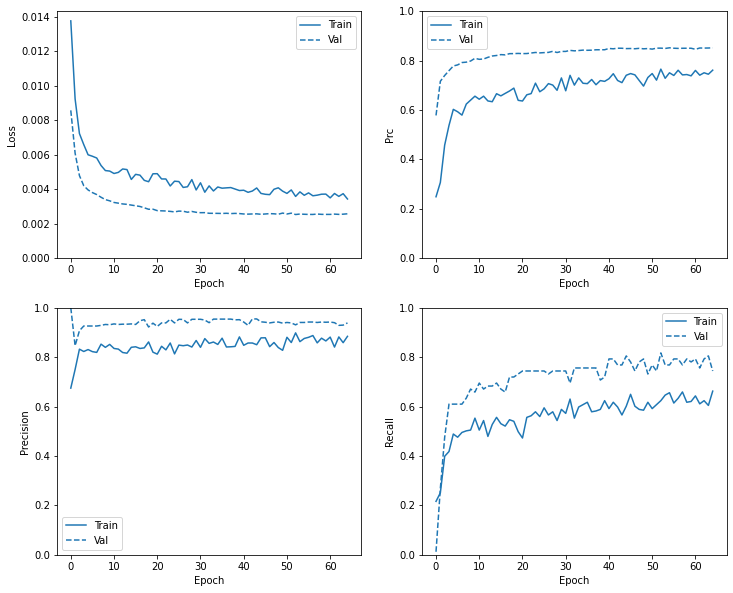

In [26]:
plot_metrics(baseline_history)

# Diagnostic Metrics 

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [28]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.002845881273970008
true positive :  76.0
false positive :  8.0
true negative :  56855.0
false negative :  23.0
accuracy :  0.9994557499885559
precision :  0.9047619104385376
recall :  0.7676767706871033
auc :  0.9340019822120667
prc :  0.8226545453071594

Legitimate Transactions Detected (True Negatives):  56855
Legitimate Transactions Incorrectly Detected (False Positives):  8
Fraudulent Transactions Missed (False Negatives):  23
Fraudulent Transactions Detected (True Positives):  76
Total Fraudulent Transactions:  99


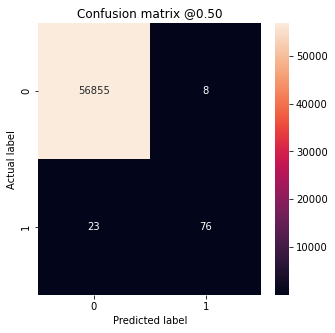

In [29]:
# Evaluate your model on test dataset.
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

# Reciever Operatering Curve 

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

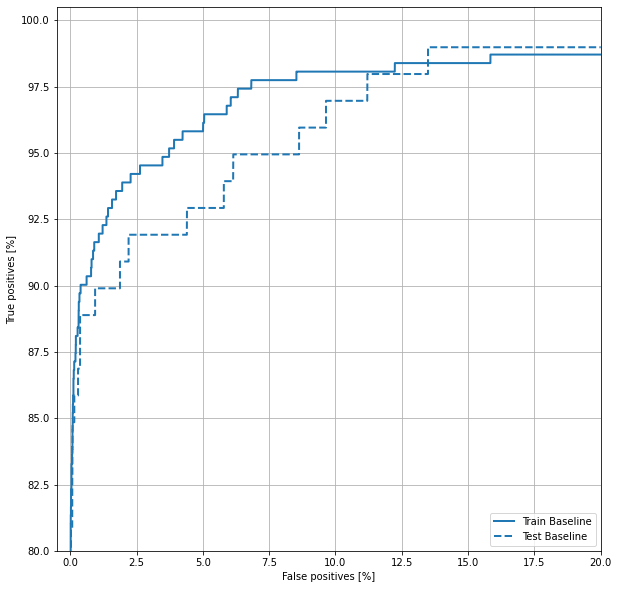

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

# Plot the Area Under Precision Recall Curve (AUPRC)

In [32]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

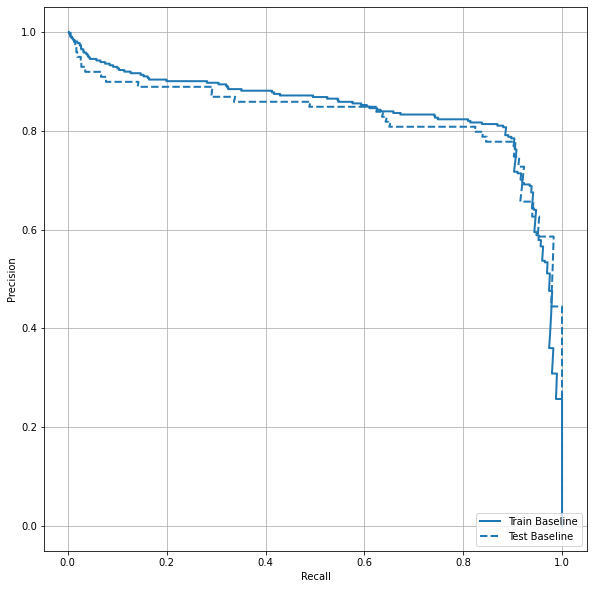

In [33]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

# Using class weights for imabalanced dataset

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [34]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
    
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)

Weight for class 0: 0.50
Weight for class 1: 289.44


# Now we use these weights and re-train the model

In [35]:
# Train the model with class weights.
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
90/90 [==============================] - 1s 4ms/step - loss: 2.7256 - true positive: 121.0000 - false positive: 167.0000 - true negative: 238661.0000 - false negative: 289.0000 - accuracy: 0.9981 - precision: 0.4201 - recall: 0.2951 - auc: 0.7303 - prc: 0.2434 - val_loss: 0.0088 - val_true positive: 19.0000 - val_false positive: 4.0000 - val_true negative: 45483.0000 - val_false negative: 63.0000 - val_accuracy: 0.9985 - val_precision: 0.8261 - val_recall: 0.2317 - val_auc: 0.8830 - val_prc: 0.4929
Epoch 2/100
90/90 [==============================] - 0s 1ms/step - loss: 1.4418 - true positive: 133.0000 - false positive: 467.0000 - true negative: 181498.0000 - false negative: 178.0000 - accuracy: 0.9965 - precision: 0.2217 - recall: 0.4277 - auc: 0.7733 - prc: 0.2486 - val_loss: 0.0092 - val_true positive: 50.0000 - val_false positive: 7.0000 - val_true negative: 45480.0000 - val_false negative: 32.0000 - val_accuracy: 0.9991 - val_precision: 0.8772 - val_recall: 0.6098 - va

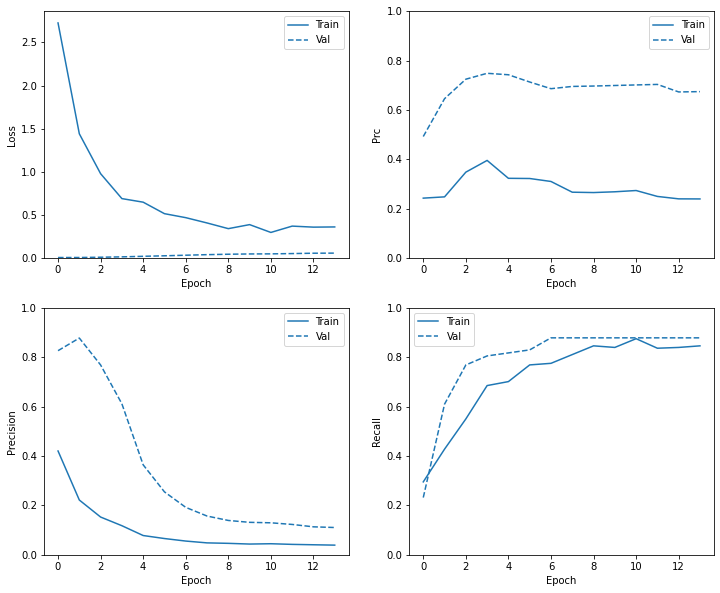

In [36]:
plot_metrics(weighted_history)

# Diagnostic Metrics -- weighted class 

In [37]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.017389826476573944
true positive :  78.0
false positive :  65.0
true negative :  56798.0
false negative :  21.0
accuracy :  0.9984902143478394
precision :  0.5454545617103577
recall :  0.7878788113594055
auc :  0.9571707844734192
prc :  0.7003578543663025

Legitimate Transactions Detected (True Negatives):  56798
Legitimate Transactions Incorrectly Detected (False Positives):  65
Fraudulent Transactions Missed (False Negatives):  21
Fraudulent Transactions Detected (True Positives):  78
Total Fraudulent Transactions:  99


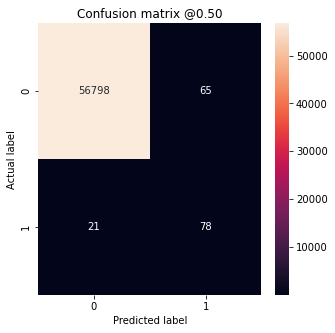

In [38]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

# compared to metrics *without* class weights

loss :  0.0025574234314262867
true positive :  69.0
false positive :  6.0
true negative :  56862.0
false negative :  25.0
accuracy :  0.9994557499885559
precision :  0.9200000166893005
recall :  0.7340425252914429
auc :  0.9412895441055298
prc :  0.8399971127510071

Legitimate Transactions Detected (True Negatives):  56862
Legitimate Transactions Incorrectly Detected (False Positives):  6
Fraudulent Transactions Missed (False Negatives):  25
Fraudulent Transactions Detected (True Positives):  69
Total Fraudulent Transactions:  94

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

# Plot the Reciever Operator Curve

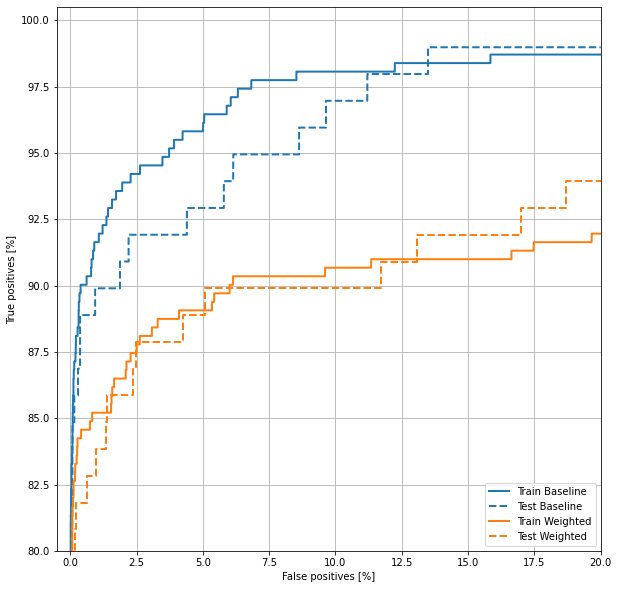

In [39]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

# Plotting AUPRC 

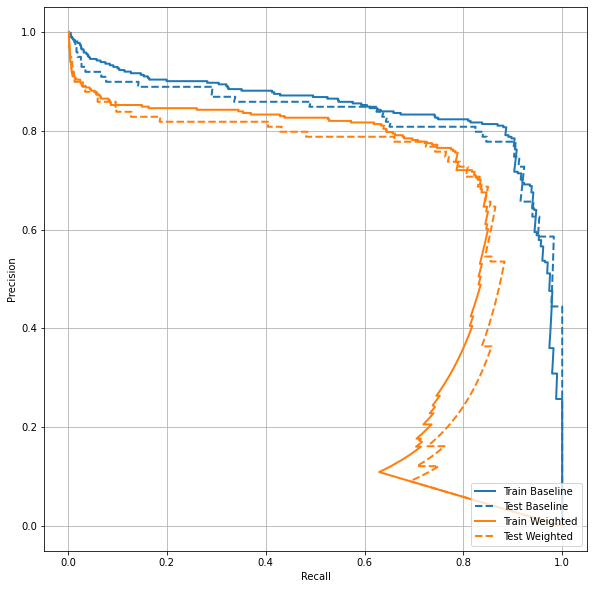

In [40]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

# Another way of dealing with an imbalanced dataset it using **oversampling**

In [41]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [42]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181965, 29)

In [43]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363930, 29)

In [44]:
# easiest way is to use td.data 
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [45]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-5.          5.         -5.          2.35104447 -3.52476591  4.36097658
 -5.         -5.         -0.35826554 -4.64158739  4.31457878 -4.61978138
 -1.91911153 -5.         -0.24895403 -5.         -5.         -3.76234308
  0.06124262 -4.54528794  5.         -5.          5.         -1.05886965
  0.50587419 -0.22615014  3.1688201   2.90940077 -1.4570092 ]

Label:  1


In [46]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

Instructions for updating:
Use `tf.data.Dataset.random(...)`.


In [47]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.50048828125


In [48]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

In [51]:
# resampled_model = make_model()
# resampled_model.load_weights(initial_weights)

# # Reset the bias to zero, since this dataset is balanced.
# output_layer = resampled_model.layers[-1] 
# output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

# resampled_history = resampled_model.fit(
#     resampled_ds,
#     epochs=EPOCHS,
#     steps_per_epoch=resampled_steps_per_epoch,
#     callbacks=[early_stopping],
#     validation_data=val_ds)

In [52]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 1s 36ms/step - loss: 1.3586 - true positive: 8496.0000 - false positive: 9455.0000 - true negative: 67781.0000 - false negative: 12190.0000 - accuracy: 0.7790 - precision: 0.4733 - recall: 0.4107 - auc: 0.7840 - prc: 0.5494 - val_loss: 0.7087 - val_true positive: 60.0000 - val_false positive: 20152.0000 - val_true negative: 25335.0000 - val_false negative: 22.0000 - val_accuracy: 0.5573 - val_precision: 0.0030 - val_recall: 0.7317 - val_auc: 0.6980 - val_prc: 0.0374
Epoch 2/1000
20/20 [==============================] - 0s 17ms/step - loss: 0.9108 - true positive: 11764.0000 - false positive: 8948.0000 - true negative: 11256.0000 - false negative: 8992.0000 - accuracy: 0.5620 - precision: 0.5680 - recall: 0.5668 - auc: 0.5971 - prc: 0.7123 - val_loss: 0.6555 - val_true positive: 70.0000 - val_false positive: 17179.0000 - val_true negative: 28308.0000 - val_false negative: 12.0000 - val_accuracy: 0.6227 - val_precision: 0.0041 - val_r

In [ ]:
plot_metrics(resampled_history)

NameError: name 'plot_metrics' is not defined

# Using XGBoost instead of a neural net

We know that using a neural net might not be the best model for this use case. What about the using boosted decision tree instead? And also what about using **Synthetic Minority Over-sampling Technique (SMOTE)** for handling our imbalanced dataset? 

source: https://blog.dominodatalab.com/credit-card-fraud-detection-using-xgboost-smote-and-threshold-moving#:~:text=%20Credit%20Card%20Fraud%20Detection%20using%20XGBoost%2C%20SMOTE%2C,will%20now%20train%20an%20XGBoost%20classifier%2C...%20More%20

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE # conda install imbalanced-learn
from xgboost import XGBClassifier
from xgboost import Booster
from xgboost import DMatrix
from sklearn import metrics
from datetime import datetime
dataDF = pd.read_csv("./creditcard.csv")
dataDF.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploratory Data Analysis

<AxesSubplot:title={'center':'Class distribution of the target variable'}>

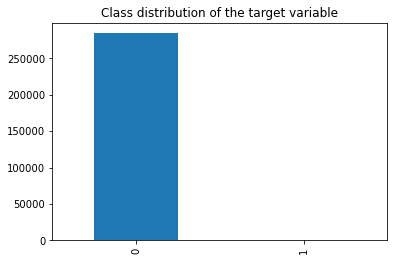

In [4]:
value_counts = dataDF["Class"].value_counts()
value_counts.plot(kind="bar", title="Class distribution of the target variable")

In [5]:
pd.set_option("display.float_format", lambda x: "%.3f" % x)
dataDF.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,...,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,94813.860,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,88.350,0.002
std,47488.146,1.959,1.651,1.516,1.416,1.380,1.332,1.237,1.194,1.099,...,0.735,0.726,0.624,0.606,0.521,0.482,0.404,0.330,250.120,0.042
min,0.000,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,...,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,54201.500,-0.920,-0.599,-0.890,-0.849,-0.692,-0.768,-0.554,-0.209,-0.643,...,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.600,0.000
50%,84692.000,0.018,0.065,0.180,-0.020,-0.054,-0.274,0.040,0.022,-0.051,...,-0.029,0.007,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000,0.000
75%,139320.500,1.316,0.804,1.027,0.743,0.612,0.399,0.570,0.327,0.597,...,0.186,0.529,0.148,0.440,0.351,0.241,0.091,0.078,77.165,0.000
max,172792.000,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,...,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


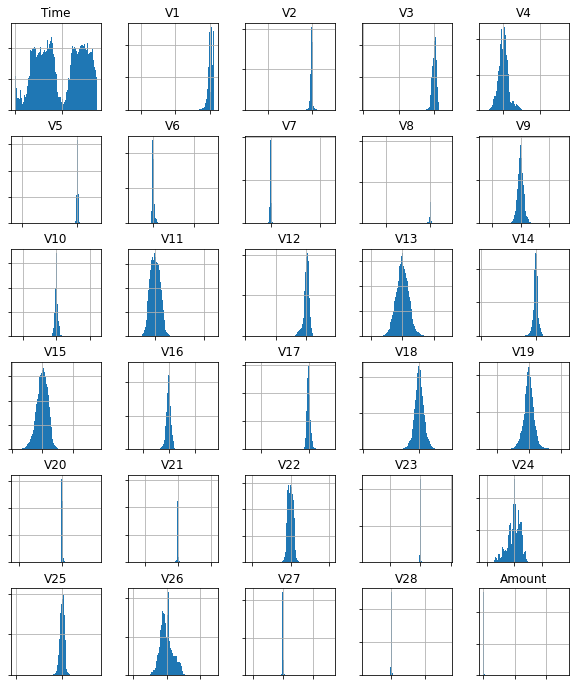

In [6]:
ax = dataDF.drop("Class", axis=1).hist(figsize=(10,12),bins=100)
# We hide the axes' labels to make the plot neater and more compact
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])

In [13]:
dataDF["Hour"] = dataDF["Time"].apply(datetime.fromtimestamp).dt.hour

# Feature Engineering

We noticed during the exploratory analysis that the Amount column is not zero mean centered. Let's fix this, and also center the Hour attribute, which we'll be using instead of Time.

In [17]:
# convert timestamp to hours 
dataDF["Hour"] = dataDF["Time"].apply(datetime.fromtimestamp).dt.hour

In [14]:
trainDF, testDF = train_test_split(dataDF, test_size=0.2, random_state=1234, stratify=dataDF[["Class"]])
tr_value_counts = trainDF["Class"].value_counts()
print("Fraudulent transactions are %.2f%% of the training set." % (tr_value_counts[1] * 100 / len(trainDF)))
tst_value_counts = testDF["Class"].value_counts()
print("Fraudulent transactions are %.2f%% of the test set." % (tst_value_counts[1] * 100 / len(testDF)))

Fraudulent transactions are 0.17% of the training set.
Fraudulent transactions are 0.17% of the test set.


We noticed during the exploratory analysis that the Amount column is not zero mean centered. Let's fix this, and also center the Hour attribute, which we'll be using instead of Time.

In [18]:

trainDF_norm = trainDF.copy()
trainDF_norm["Amount"] = trainDF["Amount"].subtract(trainDF["Amount"].mean())
trainDF_norm["Hour"] = trainDF["Hour"].subtract(trainDF["Hour"].mean())
testDF_norm = testDF.copy()
testDF_norm["Amount"] = testDF["Amount"].subtract(testDF["Amount"].mean())
testDF_norm["Hour"] = testDF["Hour"].subtract(testDF["Hour"].mean())
trainDF = trainDF_norm
testDF = testDF_norm

In [19]:
# drop because using "Hour" instead
trainDF = trainDF.drop(["Time"], axis=1)
testDF = testDF.drop(["Time"], axis=1)

In [20]:
X_train = trainDF.iloc[:, trainDF.columns != "Class"]
y_train = trainDF.iloc[:, trainDF.columns == "Class"]
X_test = testDF.iloc[:, testDF.columns != "Class"]
y_test = testDF.iloc[:, testDF.columns == "Class"]
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour
135152,1.082,-0.075,1.395,1.373,-0.958,0.077,-0.625,0.205,0.861,-0.248,...,-0.012,0.204,0.063,0.399,0.298,-0.400,0.089,0.039,-76.750,5.578
103706,1.013,0.188,1.615,2.594,-0.609,0.839,-0.683,0.400,-0.260,0.597,...,0.017,0.218,0.074,0.230,0.185,-0.046,0.059,0.027,-81.450,2.578
231651,-0.701,0.090,1.540,-3.114,0.458,0.431,0.183,0.195,-1.230,-0.503,...,-0.069,-0.367,-0.449,-1.461,0.628,-0.475,0.004,0.027,-76.250,-0.422
199939,-0.430,-0.595,0.676,-2.603,1.499,4.231,-1.079,1.239,-0.798,-0.003,...,-0.015,0.214,0.090,0.694,-0.698,0.592,0.158,0.166,-42.350,-3.422
103404,1.296,1.011,-3.192,0.472,3.350,2.433,0.190,0.622,-0.557,-1.487,...,-0.263,-0.825,-0.245,0.675,1.011,-0.279,0.041,0.091,-83.260,2.578


In [21]:
X_train_smote, y_train_smote = SMOTE(random_state=1234).fit_resample(X_train, y_train)
smote_value_counts = y_train_smote["Class"].value_counts()
print("Fraudulent transactions are %.2f%% of the test set." % (smote_value_counts[0] * 100 / len(y_train_smote)))

Fraudulent transactions are 50.00% of the test set.


# creating our xgboost search with stratified k folds cross validation 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

This cross-validation object is a variation of KFold that returns stratified folds.
The folds are made by preserving the percentage of samples for each class.

In [22]:
def xgboost_search(X, y, search_verbose=1):
    params = {
        "gamma":[0.5, 1, 1.5, 2, 5],
        "max_depth":[3,4,5,6],
        "min_child_weight": [100],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "learning_rate": [0.1, 0.01, 0.001]
    }
    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)
    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)
    grid_search.fit(X, y)
    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)
    return grid_search.best_params_

In [23]:
rows = random.sample(np.arange(0,len(X_train_smote.index)).tolist(), 5000)
model_params = xgboost_search(X_train_smote.iloc[rows,], y_train_smote.iloc[rows,])

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best estimator: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, eval_metric='auc', gamma=2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=100, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
Parameters:  {'colsample_bytree': 0.6, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 100, 'subsample': 1.0}
Highest AUC: 0.98


In [24]:
model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model.set_params(**model_params)
model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, eval_metric='auc', gamma=2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=100, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Model Evalutation

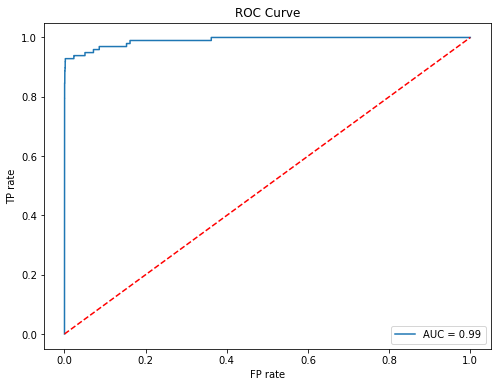

In [26]:
y_pred = model.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

In [27]:
t_opt_idx = np.argmax(tp_r - fp_r)
t_opt = t[t_opt_idx]
print("Threshold value is: %.2f" % t_opt)

Threshold value is: 0.83


Selecting the optimal threshold value can be performed in a number of ways. Looking at the ROC curve, we can intuitively see that the best performance (misclassification costs aside) would be yield by the threshold that puts us in the top left section of the curve (i.e. TP rate is high, FP rate is low). With this criterion in mind, we can define a distance metric to the top left corner of the curve and find a threshold that minimises it.

Text(0.5, 0.98, 'Impact of threshold adjustment on the error matrix')

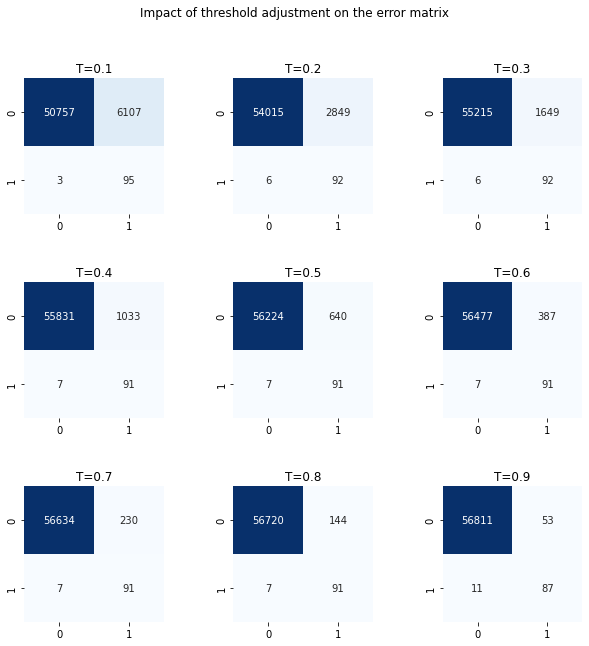

In [28]:
y_pred = model.predict_proba(X_test)[:,1]
fig, axes = plt.subplots(3,3, figsize=(10,10))
for t, ax in enumerate(axes.flat):
    threshold = (t+1)/10
    y_pred_int = (y_pred > threshold).astype(int)
    c_matrix = metrics.confusion_matrix(y_test, y_pred_int)
    sns.heatmap(c_matrix, annot=True, cmap="Blues", fmt="d", ax=ax, cbar=False)
    ax.title.set_text("T=%.1f" % threshold)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the error matrix")

In [29]:
model.save_model("smote_fraud.xgb")

Comparing false positive rates -- because that's what we care about since it's fraud detection 

* neural net - 25 false positives 
* weighted neural net - 21 false positives 
* xgboost with SMOTE - 7 false positives 

XGBoost + KstratifiedFolds Cross validation + SMOTE + grid search is 3 times better than a neural net! 